In [669]:
import scipy.io
from scipy.optimize import minimize
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import math
import time
from PIL import Image
from IPython import display

# Note from the author:

  - This is the most challenging assignment due to the material
  - Python does a lot of things differently, which adds to the difficulty
  
  - If you have any questions, please message me and I will be happy to help

# Load and Visualize Data

  - same data as previous week 

In [630]:
matrix = scipy.io.loadmat("ex4data1.mat")

In [631]:
X = matrix['X'] # 5000 x 400
y = matrix['y'] # 5000 x 1

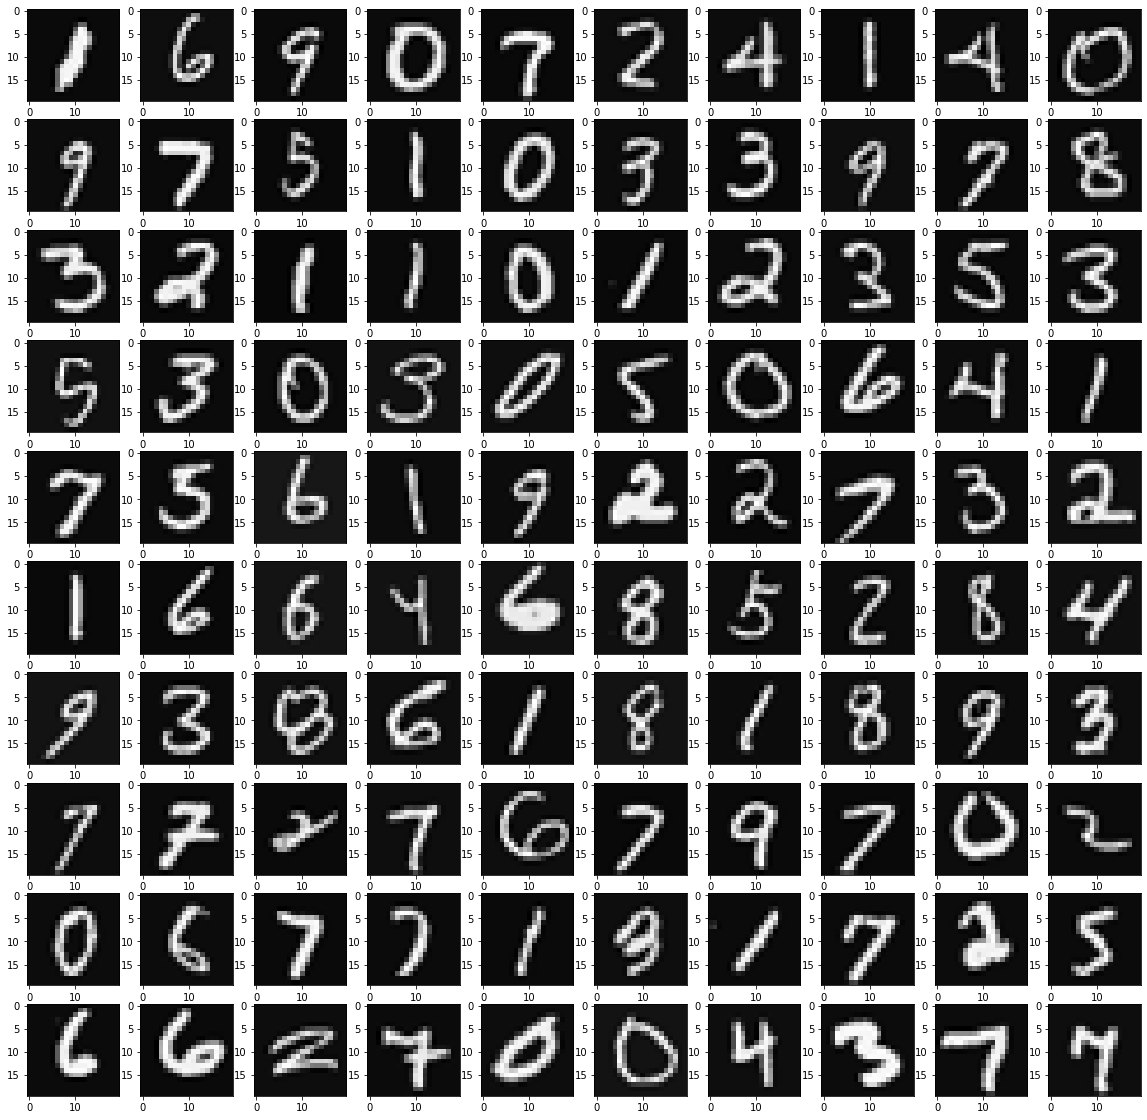

In [671]:
# to plot single image
def display_image(pixel_row):
    array = pixel_row.reshape(20,20, order='F') # reshape to desired resolution
    plt.figure()
    plt.imshow(array, cmap='gray') # build in grayscale
    plt.show()


# build 10x10 image grid
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20,20))
for i in range(10):
    for j in range(10):
        random_row = X[np.random.randint(0,5000), :]
        array = random_row.reshape(20,20, order='F') # reshape to desired resolution
        ax[i, j].imshow(array, cmap='gray') # plot on grid

# Feedforward Propagation

In [632]:
# load in pre-trained weights 
weights = scipy.io.loadmat("ex4weights.mat")
theta1 = weights["Theta1"] # 25x401
theta2 = weights["Theta2"] # 10x26

nn_params = np.concatenate([theta1.T.ravel(), theta2.T.ravel()])

In [633]:
# useful variables
num_labels = 10
hidden_layers = 25
input_layers = 400
m = len(y)
lam = 1

### Utility functions

In [649]:
def sigmoid(z):
    g = 1/(1 + np.exp((-1)*z))
    
    return g 


def sigmoid_grad(z):
    g = sigmoid(z) * (1-sigmoid(z))
    
    return g


def rand_intialize_weights(L_in, L_out):
    """
    creates random matrix of values uniformly distributed
    between 0 and 1
    
    results in random theta between -.12 and .12
    
    """
    w = np.zeros((L_out, L_in+1))
    
    epsilon_init = 0.12 # recommended value
    w = np.random.rand(L_out, L_in+1) * 2 * epsilon_init - epsilon_init

    return w


def make_y_binary(y, num_labels):
    y_temp = np.matlib.repmat(y, 1, num_labels)
    for i in range(1,num_labels+1):
        new_col = y_temp[:, i-1]
        cond = (new_col == i)
        new_col = cond.astype(int)
        y_temp[:, i-1] = new_col
        
    y_temp = y_temp.T # 10x5000 
    return y_temp


def debug_intitialize_weights(fan_out, fan_in):
    w = np.zeros((fan_out, fan_in+1))
    
    # using a range of sin will ensure range is always the same
    # makes it easier to debug
    w = np.reshape(np.sin(np.arange(1,w.size+1)),w.shape, order="F") / 10
    return w


def compute_numerical_grad(J, theta):
    """
    The following is a method to assess the cost_function correctness
    
    You compare the numerical grad (calculated here)
    with the gradient of the test data
    """
    num_grad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4
    
    for p in range(theta.size):
        perturb[p] = e
        loss1, unrolled = J(theta-perturb)
        loss2, unrolled = J(theta+perturb)
        num_grad[p] = (loss2-loss1)/(2*e)
        perturb[p] = 0
        
    return num_grad
    
    
def check_nn_grad(lam): # creates a small NN to test cost_function
    
    # parameters for small test NN
    input_layers = 3
    hidden_layers = 5
    num_labels = 3
    m = 5
    
    # random test data
    theta1 = debug_intitialize_weights(hidden_layers, input_layers)
    theta2 = debug_intitialize_weights(num_labels, hidden_layers)
    
    nn_params = np.concatenate([theta1.T.ravel(), theta2.T.ravel()])
    
    X = debug_intitialize_weights(m, input_layers - 1)
    y = (np.arange(1,m+1) % num_labels) + 1
    y = y.reshape(y.shape+(1,))
    
    # implement cost func on test data
    cost, unrolled = cost_function_nn(nn_params,
                                      X, 
                                      y,
                                      m,
                                      lam,
                                      num_labels, 
                                      hidden_layers, 
                                      input_layers)
    
    def shorthand_cost(p):
        return cost_function_nn(p, X, y, m, lam, num_labels, hidden_layers, input_layers)
    
    # get numerical gradient and compare results
    num_grad = compute_numerical_grad(shorthand_cost, nn_params)    
    results = np.column_stack((num_grad, unrolled))
    
    return results
    

def predict(theta1, theta2, X):
    m = len(X)
    num_labels = theta2.shape[0]
    
    p = np.zeros(len(X))
    
    h1 = sigmoid(np.column_stack((np.ones(len(X)), X)).dot(theta1.T)) # 5000x401 * 401x25
    h2 = sigmoid(np.column_stack((np.ones(len(h1)), h1)).dot(theta2.T)) # 5000x26 * 26x10
    
    p = np.argmax(h2, axis=1)
    
    count = 0
    for i in range(len(p)): # count number of correct matches
        if (p[i]+1)==y[i]: 
            count+=1

    return ((count)/m)*100, p

### Cost Function

In [650]:
def cost_function_nn(nn_params,
                     X, 
                     y, 
                     m, 
                     lam, 
                     num_labels, # 10
                     hidden_layers, # 25
                     input_layers): # 400
    
    # extract thetas from unrolled array
    theta1 = np.reshape(nn_params[:(input_layers+1)*hidden_layers],
        (hidden_layers, input_layers+1), 1) # 25x401
    theta2 = np.reshape(nn_params[(input_layers+1)*hidden_layers:],
        (num_labels, hidden_layers+1), order="F") # 10x26
    
    # make empty gradient matrices
    theta1_grad = np.zeros((len(theta1), len(theta1[0])))
    theta2_grad = np.zeros((len(theta2), len(theta2[0])))
    J = 0
    
    X = np.column_stack((np.ones(len(X)), X)) # add ones column
    
    # make binary matrix for y
    y_temp = make_y_binary(y, num_labels)
        
    # forward propagation
    a1 = X # 5000x401
    z2 = theta1.dot(a1.T) # 25x401 * 401x5000 = 25x5000
    z2 = np.vstack((np.ones(len(z2[0])), z2)) # add ones row; 26x5000
    a2 = sigmoid(z2[1:, :])
    a2 = np.vstack((np.ones(len(a2[0])), a2)) # add ones row; 26x5000
    z3 = theta2.dot(a2) # 10x26 * 26x5000 = 10x5000
    a3 = sigmoid(z3)
    h = a3 # predictions for each label for each example
    
    # cost function
    J = (1/m)*((-1)*(y_temp)*(np.log(h)) - (1 - y_temp)*(np.log(1 - h))).sum()
    
    """
    PART 1.2 - Add regularization
    
    note: check non-regularized cost func before continuing
    """
    J1 = J
    reg_term1 = (lam/(2*m)) * (theta1[:, 1:]**2).sum()
    reg_term2 = (lam/(2*m)) * (theta2[:, 1:]**2).sum()
    
    J = J1 + reg_term1 + reg_term2
    
    
    """
    Part 2 - Add backpropagation
    
    note: check regularized cost func before continuing
    """
    
    delta3 = a3 - y_temp # 10x5000
    delta2 = (theta2.T).dot(delta3) * sigmoid_grad(z2) # 26x10 * 10x5000 = 26x5000
    delta2 = delta2[1:, :] # 25x5000
    
    theta1_grad = theta1_grad + delta2.dot(a1) # 25x401 + 25x5000*5000x401
    theta2_grad = theta2_grad + delta3.dot(a2.T) # 10x26 + 10x5000*5000x26

    
    """
    Part 2.2 - Add regularization to backpropagation
    
    be sure to separate bias term from the rest
    """
    theta1_grad[:, 0] = (1/m) * (theta1_grad[:,0])
    theta1_grad[:, 1:] = (1/m) * (theta1_grad[:,1:] + lam*theta1[:, 1:])
    
    theta2_grad[:, 0] = (1/m) * (theta2_grad[:,0])
    theta2_grad[:, 1:] = (1/m) * (theta2_grad[:,1:] + lam*theta2[:, 1:])
    
    # unroll theta1_grad and theta2_grad into 1-D array
    unrolled = np.concatenate([theta1_grad.T.ravel(), theta2_grad.T.ravel()])
    
    return J, unrolled

In [612]:
# check that regularized cost func is correct
# should equal 0.38377 (0.28763 if unregularized)
J, unrolled = cost_function_nn(nn_params,
                                     X, 
                                     y,
                                     m,
                                     lam,
                                     num_labels,
                                     hidden_layers,
                                     input_layers)

print(J)

0.3837698590909236


### Check sigmoid gradient function

In [613]:
# test sigmoid gradient func
# should equal 0.25
print(sigmoid_grad(0))

0.25


### Gradient Checking

  - I spent the most time debugging this
  - Tips:
    - ensure you are rolling/unrolling correctly because python reshapes differently
    - add the order="F" argument to your reshaping to match matlab

In [653]:
check_comp = check_nn_grad(0)
print(check_comp)

total_diff = 0
for i in range(len(check_comp)):
    diff = check_comp[i, 1] - check_comp[i,0]
    total_diff += diff

avg_diff = total_diff/len(check_comp)
print("The average difference in the gradient check is %.10f" % avg_diff)
print("The difference should be less than 1e-9")

[[-9.27825235e-03 -9.27825236e-03]
 [ 8.89911959e-03  8.89911960e-03]
 [-8.36010761e-03 -8.36010762e-03]
 [ 7.62813550e-03  7.62813551e-03]
 [-6.74798369e-03 -6.74798370e-03]
 [-3.04979153e-06 -3.04978914e-06]
 [ 1.42869450e-05  1.42869443e-05]
 [-2.59383093e-05 -2.59383100e-05]
 [ 3.69883213e-05  3.69883234e-05]
 [-4.68759764e-05 -4.68759769e-05]
 [-1.75060086e-04 -1.75060082e-04]
 [ 2.33146358e-04  2.33146357e-04]
 [-2.87468729e-04 -2.87468729e-04]
 [ 3.35320345e-04  3.35320347e-04]
 [-3.76215585e-04 -3.76215587e-04]
 [-9.62660596e-05 -9.62660620e-05]
 [ 1.17982666e-04  1.17982666e-04]
 [-1.37149705e-04 -1.37149706e-04]
 [ 1.53247082e-04  1.53247082e-04]
 [-1.66560294e-04 -1.66560294e-04]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 9.74006970e-02  9.74006970e-02]
 [ 1.64090819e-01  1.64090819e-01]
 [ 5.75736494e-02  5.75736493e-02]
 [ 5.04575855e-02  5.04575855e-02]
 [ 1.64567932e-01  1.64567932e-01]
 [ 5.77867378e-02  5.77867378e-02]
 [ 5.07530173e-02  5

### Learning the parameters

In [636]:
# initialize parameters
theta1_init = rand_intialize_weights(input_layers, hidden_layers) # 400x25
theta2_init = rand_intialize_weights(hidden_layers, num_labels) #25x10

nn_params_init = np.concatenate([theta1_init.T.ravel(), theta2_init.T.ravel()])

In [637]:
def shorthand_cost(p):
    return cost_function_nn(p, X, y, m, lam, num_labels, hidden_layers, input_layers)

params_opt = minimize(shorthand_cost, 
                     nn_params_init,
                     method="CG",
                     jac=True,
                     options={'maxiter':50, "disp":True}) 

         Current function value: 0.436803
         Iterations: 50
         Function evaluations: 116
         Gradient evaluations: 116


# Assessing the Model

  - here we use the learned parameters to predit handwritten digits
  - the function predict will return the model's accuracy 

In [638]:
# Extract theta
nn_params = params_opt.x

In [639]:
# separate theta1 and theta2
theta1 = np.reshape(nn_params[:(input_layers+1)*hidden_layers],
    (hidden_layers, input_layers+1), 1) # 25x401
theta2 = np.reshape(nn_params[(input_layers+1)*hidden_layers:],
    (num_labels, hidden_layers+1), order="F") # 10x26

(25, 401)
(10, 26)


In [644]:
acc, preds = predict(theta1, theta2, X)

In [648]:
# Accuracy should be 95.3% +- 1
print("The NN accuracy is: %.2f" % acc)

The NN accuracy is: 96.18


# Visualize the model's work

  - we will randomly select an image, display it, and show the NN guess

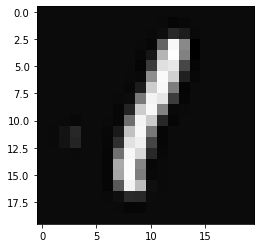

Prediction:  1


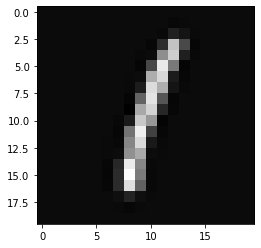

Prediction:  1


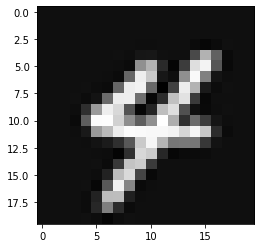

Prediction:  4


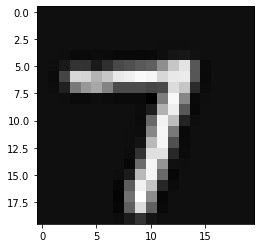

Prediction:  7


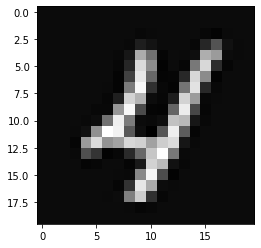

Prediction:  4


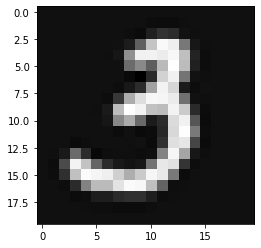

Prediction:  3


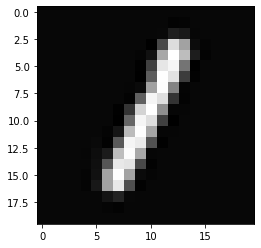

Prediction:  1


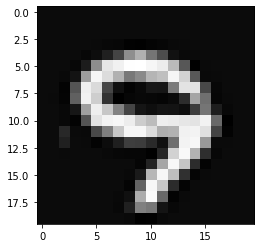

Prediction:  9


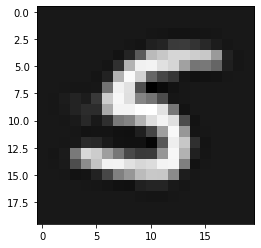

Prediction:  5


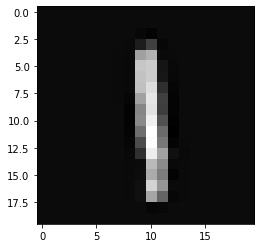

Prediction:  1


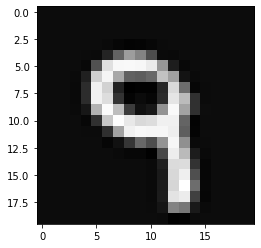

Prediction:  9


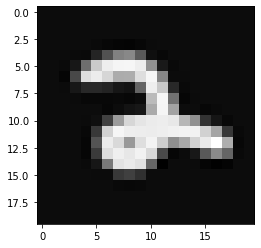

Prediction:  2


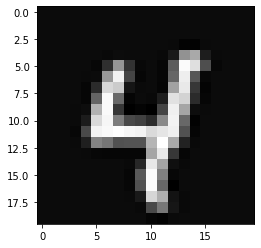

Prediction:  4


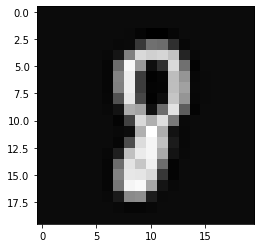

Prediction:  8


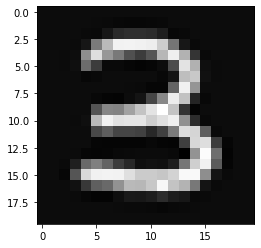

Prediction:  3


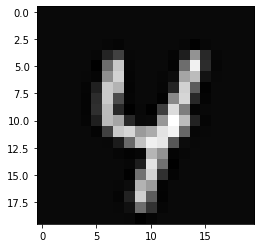

Prediction:  4


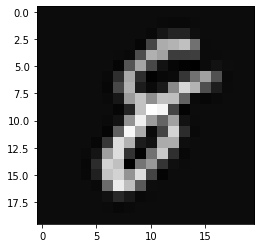

Prediction:  8


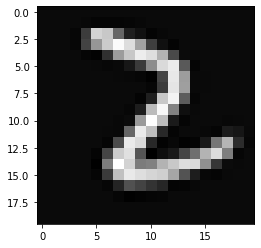

Prediction:  2


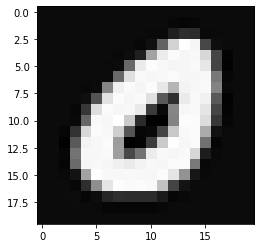

Prediction:  10


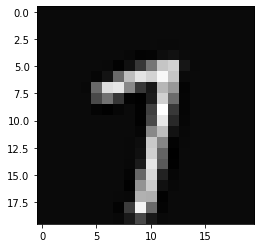

Prediction:  7


In [674]:
EXAMPLES = 10 # how many pictures you want to see it predict

for i in range(EXAMPLES):
    row_index = np.random.randint(0,5000)
    random_row = X[row_index]

    display_image(random_row)
    print("Prediction: ", preds[row_index]+1)
    time.sleep(1)